In [25]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# The Kalman filter belongs to a family of filters called Bayesian filters

In [27]:
# TO SET THE MOOD FOR THE EXAMPLE UNDERSTAND THAT THE DOG COULD BE IN ANY 1 OF 10 PLACES. 

belief = np.array([1/10]*10)
belief

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [28]:
# The belief . In Bayesian statistics this is called our prior. It basically means the probability prior to incorporating measurements or other information.
# More completely, this is called the prior probability distribution, but that is a mouthful and so it is normally shorted to prior. 
# A probability distribution is a collection of all possible probabilities for an event. 
# Probability distributions always to sum to 1 because something had to happen; the distribution lists all the different somethings and the probability of each.

In [29]:
# I'm sure you've used probabilities before - as in "the probability of rain today is 30%". The last paragraph sounds like more of that. But Bayesian statistics was a revolution in probability because it treats the probability as a belief about a single event. Let's take an example. I know if I flip a fair coin a infinitely many times 50% of the flips will be heads and 50% tails. That is standard probability, not Bayesian, and is called frequentist statistics to distinguish it from Bayes. Now, let's say I flip the coin one more time. Which way do I believe it landed? Frequentist probablility has nothing to say about that; it will merely state that 50% of coin flips land as heads. Bayes treats this as a belief about a single event - the strength of my belief that this specific coin flip is heads is 50%.

In [30]:
# There are more differences, but for now recognize that Bayesian statistics reasons about our belief about a single event, whereas frequentists reason about collections of events. In this rest of this chapter, and most of the book, when I talk about the probability of something I am referring to the probability that some specific thing is true. When I do that I'm taking the Bayesian approach.

# Now let's create a map of the hallway in another list. Suppose there are first two doors close together, and then another door quite a bit further down the hallway. We will use 1 to denote a door, and 0 to denote a wall:

In [31]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])


belief = np.array([1./3, 1./3, 0, 0, 0, 0, 0, 0, 1./3, 0])


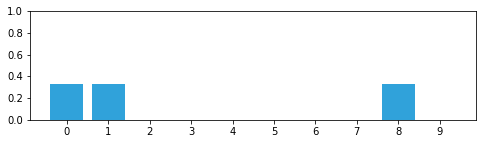

In [38]:
fig = plt.figure(figsize=(8,2))

ax = plt.gca()
x = np.arange(len(belief))
ax.bar(x, belief, color='#30a2da',)
plt.ylim(0,1)
plt.xticks(np.asarray(x), x)


plt.show()

In [39]:
# We call this a multimodal distribution because we have multiple beliefs about the position of our dog. Of course we are not saying that we think he is simultaneously in three different locations, merely that so far we have narrowed down our knowledge in his position to be one of these three locations. My (Bayesian) belief is that there is a 33.3% chance of being at door 0, 33.3% at door 1, and a 33.3% chance of being at door 8.

# I hand coded the belief array in the code above. How would we implement this in code? Well, hallway represents each door as a 1, and wall as 0, so we will multiply the hallway variable by the percentage, like so;
pbelief = hallway * (1/3)
np.set_printoptions(precision=3)
print(pbelief)

[0.333 0.333 0.    0.    0.    0.    0.    0.    0.333 0.   ]


In [40]:
# Can we deduce where Simon is at the end of that sequence? Of course! Given the hallway's layout there is only one place where you can be in front of a door, move once to the right, and be in front of another door, and that is at the left end. Therefore we can confidently state that Simon is in front of the second doorway. If this is not clear, suppose Simon had started at the second or third door. After moving to the right, his sensor would have returned 'wall'. That doesn't match the sensor readings, so we know he didn't start there. We can continue with that logic for all the remaining starting positions. Therefore the only possibility is that he is now in front of the second door. We denote this in Python with:
belief = np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
print(belief)


[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [41]:
# Obviously I carefully constructed the hallway layout and sensor readings to give us an exact answer quickly. Real problems will not be so clear cut. But this should trigger your intuition - the first sensor reading only gave us very low probabilities (0.333) for Simon's location, but after a position update and another sensor reading we knew much more about where he is. You might suspect, correctly, that if you had a very long hallway with a large number of doors that after several sensor readings and positions updates we would either be able to know where Simon was, or have the possibilities narrowed down to a small number of possibilities. For example, suppose we had a long sequence of "door, right, door, right, wall, right, wall, right, door, right, door, right, wall, right, wall, right, wall, right, wall, right, door". Simon could only have started in a location where his movements had a door sequence of [1,1,0,0,1,1,0,0,0,0,1] in the hallway. There might be only one match for that, or at most a few. Either way we will be far more certain about his position then when we started.

# We could work through the code to implement this solution, but instead let us consider a real world complication to the problem.


[0.3 0.3 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.1]
sum = 1.6000000000000003


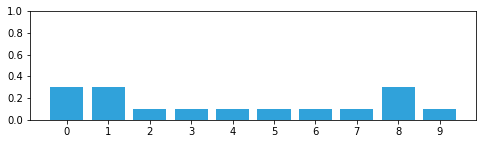

In [44]:
# Noisy Sensors
# 18

# Perfect sensors are rare. Perhaps the sensor would not detect a door if Simon sat in front of it while scratching himself, or it might report there is a door if he is facing towards the wall instead of down the hallway. So in practice when I get a report 'door' I cannot assign 1/3 as the probability for each door. I have to assign something less than 1/3 to each door, and then assign a small probability to each blank wall position.

# At this point it doesn't matter exactly what numbers we assign; let us say that the probability of the sensor being right is 3 times more likely to be right than wrong. How would we do this?

# At first this may seem like an insurmountable problem. If the sensor is noisy it casts doubt on every piece of data. How can we conclude anything if we are always unsure?

# The answer, as with the problem above, is probabilities. We are already comfortable assigning a probabilistic belief about the location of the dog; now we have to incorporate the additional uncertainty caused by the sensor noise. Lets say we get a reading of 'door'. We already said that the sensor is three times as likely to be correct as incorrect, so we should scale the probability distribution by 3 where there is a door. If we do that the result will no longer be a probability distribution, but we will learn how to correct that in a moment.

# Let's look at that in Python code.

# Here I use the variable z to denote the measurement as that is the customary choice in the literature (y is also commonly used).

def update(map_, belief, z, correct_scale):
    for i, val in enumerate(map_):
        if val == z:
            belief[i] *= correct_scale

belief = np.array([0.1] * 10)
reading = 1 # 1 is 'door'
update(hallway, belief, z=1, correct_scale=3.)

print(belief)
print('sum =', sum(belief))
fig = plt.figure(figsize=(8,2))

ax = plt.gca()
x = np.arange(len(belief))
ax.bar(x, belief, color='#30a2da',)
plt.ylim(0,1)
plt.xticks(np.asarray(x), x)


plt.show()


In [45]:
# We can see that this is not a probability distribution because it does not sum to 1.0. But we can see that the code is doing mostly the right thing - the doors are assigned a number (0.3) that is 3 times higher than the walls (0.1). All we need to do is normalize the result so that the probabilities correctly sum to 1.0. Normalization is done by dividing each element by the sum of all elements in the list.

# Also, it is a bit odd to be talking about "3 times as likely to be right as wrong". We are working in probabilities, so let's specify the probability of the sensor being correct, and computing the scale factor from that.


In [46]:
def normalize(distribution):
    assert distribution.dtype.kind == 'f'
    """ Normalize a probability distribution so it sums to 1.0"""
    distribution /= sum(distribution.astype(float)) 

In [47]:
def update(map_, belief, z, prob_correct):
    scale = prob_correct / (1. - prob_correct)
    for i, val in enumerate(map_):
        if val == z:
            belief[i] *= scale
    normalize(belief)

sum = 1.0
probability of door = 0.1875
probability of wall = 0.06249999999999999


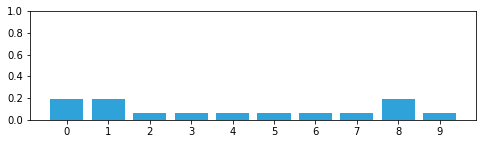

In [50]:
belief = np.array([0.1] * 10)
update(hallway, belief, 1, prob_correct=.75)
print('sum =', sum(belief))
print('probability of door =', belief[0])
print('probability of wall =', belief[2])

fig = plt.figure(figsize=(8,2))

ax = plt.gca()
x = np.arange(len(belief))
ax.bar(x, belief, color='#30a2da',)
plt.ylim(0,1)
plt.xticks(np.asarray(x), x)


plt.show()

In [51]:
# We can see from the output that the sum is now 1.0, and that the probability of a door vs wall is still three times larger. The result also fits our intuition that the probability of a door must be less than 0.333, and that the probability of a wall must be greater than 0.0. Finally, it should fit our intuition that we have not yet been given any information that would allow us to distinguish between any given door or wall position, so all door positions should have the same value, and the same should be true for wall positions.

In [52]:
# This result is called the posterior, which is short for posterior probability distribution. All this means is a probability distribution after incorporating the measurement information (posterior means 'after' in this context). Most of the Bayesian and Kalman filtering literature uses these terms, so you will have to get used to them.

# posterior = (prior x evidence) / normalization

In [53]:
# It is very important to learn and internalize these terms as most of the literature uses them exclusively. You will be unable to read it if these terms aren't crystal clear to you. To review, the prior is the probability distribution before including the measurement's information, and the posterior is the distribution after the measurement has been incorporated.

belief before predict = [0.35 0.1  0.2  0.3  0.   0.   0.   0.   0.   0.05]


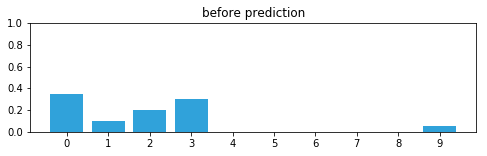

belief after predict = [0.05 0.35 0.1  0.2  0.3  0.   0.   0.   0.   0.  ]


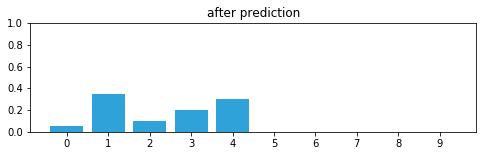

In [56]:
# Incorporating Movement Data
# Recall that the hallway is circular, so we will use modulo arithmetic to perform the shift correctly.

def perfect_predict(belief, move):
    """ move the position by 'move' spaces, where positive is to the right, 
    and negative is to the left
    """
    n = len(belief)
    result = np.zeros(n)
    for i in range(n):
        result[i] = belief[(i-move) % n]
    belief[:] = result # copy back to original array
        
belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
print('belief before predict =', belief)

fig = plt.figure(figsize=(8,2))

ax = plt.gca()
x = np.arange(len(belief))
ax.bar(x, belief, color='#30a2da',)
plt.ylim(0,1)
plt.xticks(np.asarray(x), x)
plt.title('before prediction')


plt.show()

perfect_predict(belief, 1)
print('belief after predict =', belief)

fig = plt.figure(figsize=(8,2))

ax = plt.gca()
x = np.arange(len(belief))
ax.bar(x, belief, color='#30a2da',)
plt.ylim(0,1)
plt.xticks(np.asarray(x), x)
plt.title('after prediction')


plt.show()

In [57]:
# We can see that we correctly shifted all values one position to the right, wrapping from the end of the array back to the beginning.

# You will often see this referred to as the state evolution, which is short for time evolution [7]. This term refers to how the state of the system changes over time. For filters, this time is usually discrete. For our dog tracking, the system state is the position of the dog, so the state evolution is the position after a discrete amount of time has passed. I haven't defined 'state' or 'system' yet, but I hope it is clear in context. The system is what we are trying to model or filter, and the state is it's current configuration or value. Except in simulations we rarely know the actual state, so we say our filters produce the estimated state of the system. In practice this often gets called the state, so be careful to understand if the reference is to the state of the filter (which is the estimated state), or the state of the system (which is the actual state).

# More terminology - this prediction becomes our new prior. Time has moved forward and we made a prediction without benefit of knowing the measurements.


[0.  0.  0.  0.  0.1 0.8 0.1 0.  0.  0. ]


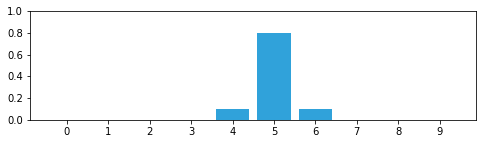

In [58]:
# Adding Noise to the Prediction
# We want to solve real world problems, and we have already stated that all sensors have noise. Therefore the code above must be wrong since it assumes we have perfect measurements. What if the sensor reported that our dog moved one space, but he actually moved two spaces, or zero? Once again this may initially sound like an insurmountable problem, but let's model it and see what happens. Since this is an example we will create a simple noise model for the sensor - later in the book we will handle more difficult errors.

# We will say that when the sensor sends a movement update, it is 80% likely to be right, and it is 10% likely to overshoot one position to the right, and 10% likely to undershoot to the left. That is, if we say the movement was 4 (meaning 4 spaces to the right), the dog is 80% likely to have moved 4 spaces to the right, 10% to have moved 3 spaces, and 10% to have moved 5 spaces.

# This is slightly harder than the math we have done so far, but it is still tractable. Each result in the array now needs to incorporate probabilities for 3 different situations. For example, consider position 9 for the case where the reported movement is 2. It should be clear that after the move we need to incorporate the probability that was at position 7 (9-2). However, there is a small chance that our dog actually moved from either 1 or 3 spaces away due to the sensor noise, so we also need to use positions 6 and 8. How much? Well, we have the probabilities, so we can just multiply and add. It would be 80% of position 7 plus 10% of position 6 and 10% of position 8! Let's try coding that:


def predict(belief, move, p_correct, p_under, p_over):
    n = len(belief)
    result = np.zeros(n)
    for i in range(n):
        result[i] = (
            belief[(i-move) % n]   * p_correct +
            belief[(i-move-1) % n] * p_over +
            belief[(i-move+1) % n] * p_under)      
    belief[:] = result

belief = np.array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
predict(belief, move=2, p_correct=.8, p_under=.1, p_over=.1)
print(belief)
fig = plt.figure(figsize=(8,2))

ax = plt.gca()
x = np.arange(len(belief))
ax.bar(x, belief, color='#30a2da',)
plt.ylim(0,1)
plt.xticks(np.asarray(x), x)


plt.show()

[0.   0.   0.   0.04 0.38 0.52 0.06 0.   0.   0.  ]


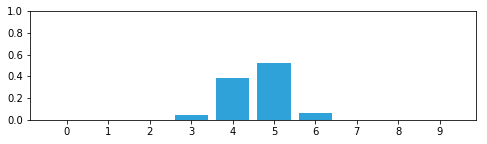

In [59]:
# The simple test case that we ran appears to work correctly. We initially believed that the dog was in position 3 with 100% certainty; after the movement update we now give an 80% probability to the dog being in position 5, and a 10% chance to undershooting to position 4, and a 10% chance of overshooting to position 6. Let us look at a case where we have multiple beliefs:
# 

belief = np.array([0, 0, .4, .6, 0, 0, 0, 0, 0, 0])
predict(belief, move=2, p_correct=.8, p_under=.1, p_over=.1)
print(belief)
fig = plt.figure(figsize=(8,2))

ax = plt.gca()
x = np.arange(len(belief))
ax.bar(x, belief, color='#30a2da',)
plt.ylim(0,1)
plt.xticks(np.asarray(x), x)


plt.show()

In [60]:
# study this 

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


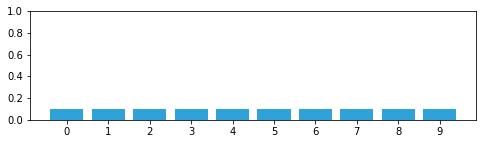

In [61]:
# This is not a coincidence, or the result of a carefully chosen example - it is always true of the evolution (predict step). This is inevitable; if our sensor is noisy we will lose a bit of information on every prediction. Suppose we were to perform the prediction an infinite number of times - what would the result be? If we lose information on every step, we must eventually end up with no information at all, and our probabilities will be equally distributed across the belief array. Let's try this with 500 iterations.
belief = np.array([1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
for i in range(500):
    predict(belief, move=1, p_correct=.8, p_under=.1, p_over=.1)
print(belief)

fig = plt.figure(figsize=(8,2))

ax = plt.gca()
x = np.arange(len(belief))
ax.bar(x, belief, color='#30a2da',)
plt.ylim(0,1)
plt.xticks(np.asarray(x), x)


plt.show()

In [63]:
# Generalizing with Convolution

# In the code above we made the assumption that the movement error is only one position. In any real problem it will almost always be possible for the error to be two, three, or more positions.

def predict(distribution, offset, kernel):
    N = len(distribution)
    kN = len(kernel)
    width = int((kN - 1) / 2)

    result = np.zeros(N)
    for i in range(N):
        for k in range (kN):
            index = (i + (width-k) - offset) % N
            result[i] += distribution[index] * kernel[k]
    distribution[:] = result[:] # update belief

In [64]:
belief = np.array([.05, .05, .05, .05, .55, .05, .05, .05, .05, .05])
predict(belief, offset=1, kernel=[.1, .8, .1])
belief


array([0.05, 0.05, 0.05, 0.05, 0.1 , 0.45, 0.1 , 0.05, 0.05, 0.05])

In [65]:
belief = np.array([.05, .05, .05, .05, .55, .05, .05, .05, .05, .05])
predict(belief, offset=3, kernel=[.1, .8, .1])
belief

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.1 , 0.45, 0.1 , 0.05])

In [66]:
kernel = np.array([1, 2, 6, 2, 1], dtype=float)
normalize(kernel)
kernel

array([0.083, 0.167, 0.5  , 0.167, 0.083])

In [67]:
# Integrating Measurements and Movement Updates
# 47

# The problem of losing information during a prediction may make it seem as if our system would quickly devolve into no knowledge. However, recall that our process is not an endless series of predictions, but of update->predict->update->predict->update->predict->update... The output of the update step, where we measure the current position, is fed into the prediction. The prediction step, with a degraded certainty, is then fed back into the update step where we measure the position again.

In [68]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
belief = np.array([.1] * 10)
update(hallway, belief, z=1, prob_correct=.75)
print(belief)

[0.188 0.188 0.062 0.062 0.062 0.062 0.062 0.062 0.188 0.062]


[0.088 0.175 0.175 0.075 0.062 0.062 0.062 0.062 0.075 0.163]


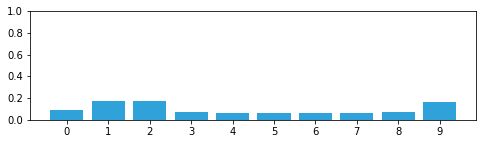

In [69]:
kernel = (.1, .8, .1)
predict(belief, 1, kernel)
print(belief)
fig = plt.figure(figsize=(8,2))

ax = plt.gca()
x = np.arange(len(belief))
ax.bar(x, belief, color='#30a2da',)
plt.ylim(0,1)
plt.xticks(np.asarray(x), x)


plt.show()

[0.157 0.313 0.104 0.045 0.037 0.037 0.037 0.037 0.134 0.097]


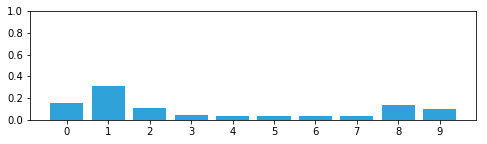

In [70]:
# So after the first update we have assigned a high probability to each door position, and a low probability to each wall position. The predict step shifted these probabilities to the right, smearing them about a bit. Now let's look at what happens at the next sense.
# 
update(hallway, belief, z=1, prob_correct=.75)
print(belief)

fig = plt.figure(figsize=(8,2))

ax = plt.gca()
x = np.arange(len(belief))
ax.bar(x, belief, color='#30a2da',)
plt.ylim(0,1)
plt.xticks(np.asarray(x), x)


plt.show()

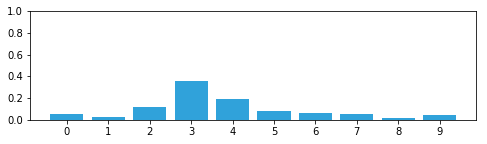

In [72]:
predict(belief, 1, kernel)
update(hallway, belief, z=0, prob_correct=.75)

fig = plt.figure(figsize=(8,2))

ax = plt.gca()
x = np.arange(len(belief))
ax.bar(x, belief, color='#30a2da',)
plt.ylim(0,1)
plt.xticks(np.asarray(x), x)


plt.show()